## Notebook 06 – Sensitivity Analysis

This notebook tests the robustness of the hypothesis by varying volatility window, test length, and regime lag parameters. 3 different values for each parameter are tested via grid search. This notebook then exports the results for downstream analysis. 

This notebook also produces and exports heatmaps for the results.

### Step 0 - Import packages and functions

In [2]:
import sys, os
sys.path.append(os.path.abspath("../src"))
import pandas as pd
import numpy as np
from itertools import product

# Plot packages
import seaborn as sns
import matplotlib.pyplot as plt

# Helper functions to compute regimes, perform walk-foward testing, and bootstrap validation
from regime_definitions import compute_market_volatility_regime, compute_cross_sectional_dispersion_regime
from backtest_engine import model_decile_long_short, walk_forward_model_apply
from stats_helpers import bootstrap_mean_diff   

C:\Users\edzz0\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


### Step 1 - Import prices, momentum, and log returns datasets

In [3]:
# Import prices
price = pd.read_parquet("../data/processed/price_filtered.parquet")

# Import momentum
momentum = pd.read_parquet("../data/processed/momentum.parquet")

# Import log returns
log_returns = pd.read_parquet("../data/processed/log_returns.parquet")

### Step 2 - Define Parameter Grid and quantile method of focus (expanding)

In [4]:
vol_windows = [10, 21, 63]  # Volatility window
test_lengths = [5, 21, 63]  # Test length for walk-forward testing
regime_lags = [0, 5, 10]    # regime lag days applied for walk-forward testing

method = 'expanding'

### Step 3 -  Run grid for testing each regime and export results

In [13]:
results_dict = {}

for regime_type, compute_regime_fn, regime_labels, outfile in [
    ("vol", compute_market_volatility_regime, ["low_vol", "high_vol"], "../data/processed/sensitivity_results.parquet"),
    ("disp", compute_cross_sectional_dispersion_regime, ["low_disp", "high_disp"], "../data/processed/sensitivity_results_disp.parquet")
]:
    results = []

    for vw, tl, lag in product(vol_windows, test_lengths, regime_lags):
        regime = compute_regime_fn(log_returns, window=vw, quantile_method=method)

        stats = {}
        for reg_label in regime_labels:
            res = walk_forward_model_apply(
                factor=momentum,
                returns=log_returns,
                regime=regime,
                target_regime=reg_label,
                model_fn=model_decile_long_short,
                lag_days=lag,
                train_window=0,
                test_window=tl,
                step=21
            )
            stats[reg_label] = res

        bootstrap_result = bootstrap_mean_diff(
            stats[regime_labels[0]]["returns"],
            stats[regime_labels[1]]["returns"],
            seed=0
        )

        results.append({
            "vol_window": vw,
            "test_len": tl,
            "lag_days": lag,
            "mean_low": stats[regime_labels[0]]["returns"].mean(),
            "mean_high": stats[regime_labels[1]]["returns"].mean(),
            "mean_diff": bootstrap_result["mean_diff"],
            "pval": bootstrap_result["p_value"]
        })

    df = pd.DataFrame(results)
    df.to_parquet(outfile)
    results_dict[regime_type] = df

### Step 4 - Plot and export heatmaps for volatility regime results

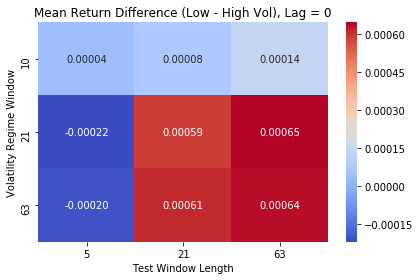

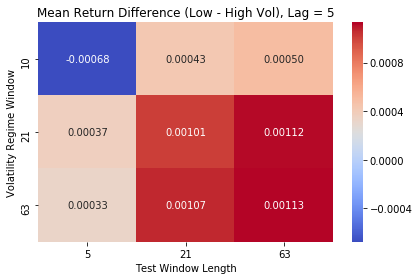

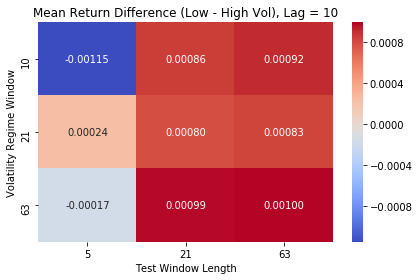

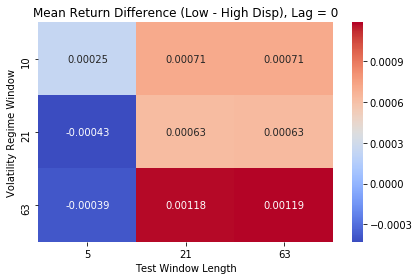

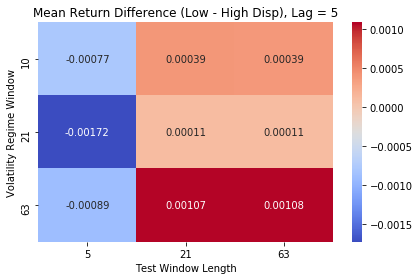

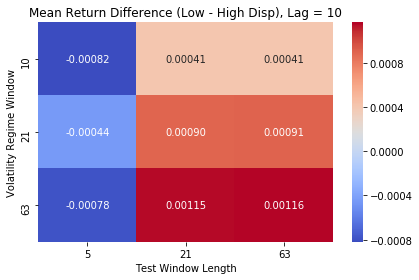

<Figure size 432x288 with 0 Axes>

In [14]:
# Use results_dict directly for plotting
for regime_type, title_prefix, filename_prefix in [
    ("vol", "Mean Return Difference (Low - High Vol)", "heatmap_mean_diff_lag"),
    ("disp", "Mean Return Difference (Low - High Disp)", "heatmap_disp_mean_diff_lag")
]:
    df = results_dict[regime_type]
    for lag in df['lag_days'].unique():
        pivot = df[df["lag_days"] == lag].pivot(
            index="vol_window",
            columns="test_len",
            values="mean_diff"
        )

        sns.heatmap(pivot, annot=True, fmt=".5f", cmap="coolwarm")
        plt.title(f"{title_prefix}, Lag = {lag}")
        plt.xlabel("Test Window Length")
        plt.ylabel("Volatility Regime Window")
        plt.tight_layout()
        plt.savefig(f"../research/plots/{filename_prefix}{lag}.png")
        plt.show()
        plt.clf()
